<a href="https://colab.research.google.com/github/AlejandroHerrera15/PROYECTO_IA/blob/main/02_preprocesado_y_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocesado y modelos

## ADAMS SoSe23
Predicting prices of AirBnB listings in the city of London: [Kaggle link](https://www.kaggle.com/competitions/adams-sose23)


In [92]:
api_token = {"username":"alejandroherrerar",
             "key":"a266538c9ed8b4d58aa6d5b3bcf32743"}

In [93]:
!rm -rf /root/.kaggle.

In [94]:
!mkdir /root/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [95]:
import json
with open('/root/.kaggle/kaggle.json','w') as file:
  json.dump(api_token,file)

In [96]:
!chmod 600 /root/.kaggle/kaggle.json

In [97]:
!kaggle competitions download -c adams-sose23

adams-sose23.zip: Skipping, found more recently modified local copy (use --force to force download)


In [98]:
!unzip adams-sose23

Archive:  adams-sose23.zip
replace reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: reviews.csv             
  inflating: test.csv                
  inflating: train.csv               


# 1 Cargar base

In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
#bibliotecas de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc

## Data
import pandas as pd
import numpy as np
from itertools import product
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

## Modelling
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report
import math


In [100]:
df_train = pd.read_csv('train.csv')
df_train.head()

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,...,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,...,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97,6XDPZPGLSR
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,...,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73,SND9OPN6IY
3,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,none,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...,https://a0.muscache.com/im/pictures/7c2b2fcc-e...,3361233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,flexible,NaN,SE3B7BXN9G
4,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",none,NaN,NaN,"I am very happy for your visit, but please car...",https://a0.muscache.com/im/pictures/ca1494da-f...,94317022,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.32,E0C82VK0VF


In [101]:
tabla = df_train.copy()
tabla.drop(['name', 'summary', 'space', 'amenities', 'description','neighborhood_overview','transit','house_rules','picture_url','host_id','host_since', 'listing_id', 'zipcode'],axis=1,inplace=True)

In [102]:
print(tabla.shape)

(55284, 29)


# 2 Tratamiento de datos

### 2.1 Nulos

Ya que no hay variables con una cantidad de datos nulos tan significativa que supere el 50% de sus datos, se decide no eliminar ninguna variable. En este caso se optará por llenar esos datos con la mediana o la moda según el caso.

In [103]:
k = tabla.isna().sum()
k[k!=0]

host_response_time             17802
host_response_rate             17802
host_is_superhost                111
host_total_listings_count        111
host_has_profile_pic             111
host_identity_verified           111
neighbourhood                    147
bathrooms                         70
bedrooms                          62
beds                             262
review_scores_rating           13415
review_scores_accuracy         13448
review_scores_cleanliness      13442
review_scores_checkin          13483
review_scores_communication    13446
review_scores_location         13480
review_scores_value            13480
reviews_per_month              12380
dtype: int64

In [104]:
tabla['host_response_time'].fillna(tabla['host_response_time'].mode()[0], inplace=True)
tabla['host_response_rate'].fillna(tabla['host_response_rate'].mode()[0], inplace=True)
tabla['host_is_superhost'].fillna(tabla['host_is_superhost'].mode()[0], inplace=True)
tabla['host_total_listings_count'].fillna(tabla['host_total_listings_count'].median(), inplace=True)
tabla['host_has_profile_pic'].fillna(tabla['host_has_profile_pic'].mode()[0], inplace=True)
tabla['host_identity_verified'].fillna(tabla['host_identity_verified'].mode()[0], inplace=True)
tabla.dropna(subset=['neighbourhood'], inplace=True)
#tabla.dropna(subset=['zipcode'], inplace=True)
tabla['bathrooms'].fillna(tabla['bathrooms'].mode()[0], inplace=True)
tabla['bedrooms'].fillna(tabla['bedrooms'].mode()[0], inplace=True)
tabla['beds'].fillna(tabla['beds'].mode()[0], inplace=True)
tabla['review_scores_rating'].fillna(tabla['review_scores_rating'].mode()[0], inplace=True)
tabla['review_scores_accuracy'].fillna(tabla['review_scores_accuracy'].mode()[0], inplace=True)
tabla['review_scores_cleanliness'].fillna(tabla['review_scores_cleanliness'].mode()[0], inplace=True)
tabla['review_scores_checkin'].fillna(tabla['review_scores_checkin'].mode()[0], inplace=True)
tabla['review_scores_communication'].fillna(tabla['review_scores_communication'].mode()[0], inplace=True)
tabla['review_scores_location'].fillna(tabla['review_scores_location'].mode()[0], inplace=True)
tabla['review_scores_value'].fillna(tabla['review_scores_value'].mode()[0], inplace=True)
tabla['reviews_per_month'].fillna(tabla['reviews_per_month'].mode()[0], inplace=True)

In [105]:
k_2 = tabla.isnull().sum()
k_2

experiences_offered            0
host_response_time             0
host_response_rate             0
host_is_superhost              0
host_total_listings_count      0
host_has_profile_pic           0
host_identity_verified         0
neighbourhood                  0
neighbourhood_cleansed         0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
bed_type                       0
price                          0
guests_included                0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
cancellation_policy            0
reviews_per_month              0
dtype: int64

In [106]:
tabla.shape

(55137, 29)

### 2.2 Normalización

In [107]:
# Eliminación de variables que se correlacionan
tabla_limpia = tabla.copy()
tabla_limpia.drop(['review_scores_rating', 'accommodates', 'bedrooms', 'review_scores_accuracy','host_has_profile_pic', 'bed_type'], axis=1, inplace=True)

In [108]:
tabla_limpia.shape

(55137, 23)

In [109]:
tabla_limpia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55137 entries, 0 to 55283
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   experiences_offered          55137 non-null  object 
 1   host_response_time           55137 non-null  object 
 2   host_response_rate           55137 non-null  object 
 3   host_is_superhost            55137 non-null  object 
 4   host_total_listings_count    55137 non-null  float64
 5   host_identity_verified       55137 non-null  object 
 6   neighbourhood                55137 non-null  object 
 7   neighbourhood_cleansed       55137 non-null  object 
 8   latitude                     55137 non-null  float64
 9   longitude                    55137 non-null  float64
 10  property_type                55137 non-null  object 
 11  room_type                    55137 non-null  object 
 12  bathrooms                    55137 non-null  float64
 13  beds            

In [110]:
tablabase=tabla_limpia.copy()
columnascategoricas=['experiences_offered', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy']
tablabase[columnascategoricas] = tablabase[columnascategoricas].astype(str)
tablabase.dtypes

experiences_offered             object
host_response_time              object
host_response_rate              object
host_is_superhost               object
host_total_listings_count      float64
host_identity_verified          object
neighbourhood                   object
neighbourhood_cleansed          object
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
bathrooms                      float64
beds                           float64
price                          float64
guests_included                  int64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
cancellation_policy             object
reviews_per_month              float64
dtype: object

In [111]:
tablabase1=pd.get_dummies(tablabase)
tablabase1

,host_total_listings_count,latitude,longitude,bathrooms,beds,price,guests_included,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_luxury_moderate,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,1.0,51.47457,-0.01062,1.0,1.0,35.0,1,10.0,10.0,10.0,...,1,0,0,0,0,0,0,1,0,0
1,1.0,51.58329,-0.12416,1.0,1.0,75.0,2,10.0,10.0,10.0,...,1,0,0,0,0,1,0,0,0,0
2,2.0,51.41634,-0.18567,1.0,2.0,120.0,2,9.0,10.0,10.0,...,0,0,0,0,0,0,0,1,0,0
3,1.0,51.45622,-0.14137,1.0,1.0,50.0,1,10.0,10.0,10.0,...,1,0,1,0,0,0,0,0,0,0
4,2.0,51.48114,-0.11219,1.0,2.0,104.0,1,10.0,10.0,10.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55279,2.0,51.47078,-0.10048,1.0,1.0,65.0,1,10.0,10.0,10.0,...,1,0,0,0,0,0,0,1,0,0
55280,1.0,51.53341,-0.00913,1.0,0.0,40.0,1,10.0,10.0,10.0,...,1,0,1,0,0,0,0,0,0,0
55281,4.0,51.57463,-0.14177,2.0,4.0,89.0,2,10.0,10.0,10.0,...,0,0,1,0,0,0,0,0,0,0
55282,1.0,51.56586,-0.10193,1.0,1.0,80.0,2,10.0,9.0,10.0,...,0,0,0,0,0,1,0,0,0,0


In [112]:
tabla_completa=pd.get_dummies(tabla)
tabla_completa

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,review_scores_rating,...,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_luxury_moderate,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,1.0,51.47457,-0.01062,2,1.0,1.0,1.0,35.0,1,95.0,...,1,0,0,0,0,0,0,1,0,0
1,1.0,51.58329,-0.12416,2,1.0,1.0,1.0,75.0,2,99.0,...,0,1,0,0,0,1,0,0,0,0
2,2.0,51.41634,-0.18567,5,1.0,1.0,2.0,120.0,2,84.0,...,0,1,0,0,0,0,0,1,0,0
3,1.0,51.45622,-0.14137,1,1.0,1.0,1.0,50.0,1,100.0,...,0,1,1,0,0,0,0,0,0,0
4,2.0,51.48114,-0.11219,3,1.0,2.0,2.0,104.0,1,100.0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55279,2.0,51.47078,-0.10048,2,1.0,1.0,1.0,65.0,1,100.0,...,0,1,0,0,0,0,0,1,0,0
55280,1.0,51.53341,-0.00913,2,1.0,1.0,0.0,40.0,1,100.0,...,0,1,1,0,0,0,0,0,0,0
55281,4.0,51.57463,-0.14177,7,2.0,3.0,4.0,89.0,2,96.0,...,0,1,1,0,0,0,0,0,0,0
55282,1.0,51.56586,-0.10193,2,1.0,1.0,1.0,80.0,2,94.0,...,0,1,0,0,0,1,0,0,0,0


# 3 Métodos supervisados

## 3.1 Modelo Regresión lineal

### Tabla completa

In [113]:
X_completa = tabla_completa.drop(['price'],axis = 1)
y_completa = tabla_completa['price'].values

In [114]:
#--------Partición de los datos------------

from sklearn.model_selection import train_test_split

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X_completa, y_completa, test_size=0.2, random_state=42)

print("Tamaño del dataset de entrenamiento: ", x_train_1.shape)
print("Tamaño del dataset de validación: ", x_test_1.shape)

Tamaño del dataset de entrenamiento:  (44109, 337)
Tamaño del dataset de validación:  (11028, 337)


In [115]:
# Se usa la función LinearRegresion() para
# estimar el modelo de regresión lineal.

# Crea el modelo
modelo_rls_1 = LinearRegression()

# Calibra el modelo
modelo_rls_1.fit(x_train_1, y_train_1)

# Imprime el intercepto
print("\nIntercepto: ", modelo_rls_1.intercept_)


Intercepto:  -67563294132.402565


In [116]:
# Pronostico para los datos de entrenamiento
y_pred_train_1 = modelo_rls_1.predict(x_train_1)
y_pred_test_1 = modelo_rls_1.predict(x_test_1)

In [117]:
# RMSE
print("RMSE train %.2f" % math.sqrt(mean_squared_error(y_train_1, y_pred_train_1)))
print("RMSE test %.2f" % math.sqrt(mean_squared_error(y_test_1, y_pred_test_1)))

print(' ')
# R2
print("Variance score train: %.2f" % r2_score(y_train_1, y_pred_train_1))
print("Variance score test: %.2f" % r2_score(y_test_1, y_pred_test_1))

print(' ')
# R2-adjusted
r2_train1 = r2_score(y_train_1, y_pred_train_1)
adj_r2_train1 = 1 - (1-r2_train1)*(len(y_train_1)-1)/(len(y_train_1)-X_completa.shape[1]-1)
print("R2-adjusted train: %.2f" % adj_r2_train1)
r2_test1 = r2_score(y_test_1, y_pred_test_1)
adj_r2_test1 = 1 - (1-r2_test1)*(len(y_test_1)-1)/(len(y_test_1)-X_completa.shape[1]-1)
print("R2-adjusted test: %.2f" % adj_r2_test1)

RMSE train 54.26
RMSE test 54.24
 
Variance score train: 0.58
Variance score test: 0.57
 
R2-adjusted train: 0.58
R2-adjusted test: 0.56


### Tabla limpia

In [118]:
X = tablabase1.drop(['price'],axis = 1)
y = tablabase1['price'].values

In [119]:
#--------Partición de los datos------------

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del dataset de entrenamiento: ", x_train.shape)
print("Tamaño del dataset de validación: ", x_test.shape)

Tamaño del dataset de entrenamiento:  (44109, 326)
Tamaño del dataset de validación:  (11028, 326)


In [120]:
# Se usa la función LinearRegresion() para
# estimar el modelo de regresión lineal.

# Crea el modelo
modelo_rls = LinearRegression()

# Calibra el modelo
modelo_rls.fit(x_train, y_train)

# Imprime el intercepto
print("\nIntercepto: ", modelo_rls.intercept_)


Intercepto:  79155890062.2856


In [121]:
# Pronostico para los datos de entrenamiento
y_pred_train = modelo_rls.predict(x_train)
y_pred_test = modelo_rls.predict(x_test)

In [122]:
# RMSE
print("RMSE train %.2f" % math.sqrt(mean_squared_error(y_train, y_pred_train)))
print("RMSE test %.2f" % math.sqrt(mean_squared_error(y_test, y_pred_test)))

print(' ')
# R2
print("Variance score train: %.2f" % r2_score(y_train, y_pred_train))
print("Variance score test: %.2f" % r2_score(y_test, y_pred_test))

print(' ')
# R2-adjusted
r2 = r2_score(y_train, y_pred_train)
adj_r2_1 = 1 - (1-r2)*(len(y_train)-1)/(len(y_train)-X.shape[1]-1)
print("R2-adjusted train: %.2f" % adj_r2_1)
r2 = r2_score(y_test, y_pred_test)
adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X.shape[1]-1)
print("R2-adjusted test: %.2f" % adj_r2)

RMSE train 56.58
RMSE test 56.59
 
Variance score train: 0.55
Variance score test: 0.53
 
R2-adjusted train: 0.54
R2-adjusted test: 0.52


## 3.2 Prueba diferentes modelos

In [123]:
#Función para reportar el error del modelo
def report_cv_score(z):

    #RMSE en prueba y entrenamiento
    lr_ts_score = z['test_score']*(-1)
    lr_tr_score = z['train_score']*(-1)
    lin_rmse_ts = np.sqrt(lr_ts_score)
    lin_rmse_tr = np.sqrt(lr_tr_score)
    print("RMSLE Test: ", "{:.5f}".format(np.mean(lin_rmse_ts)), "(±", "{:.8f}".format(np.std(lin_rmse_ts)),")")
    print("RMSLE Train: ", "{:.5f}".format(np.mean(lin_rmse_tr)), "(±", "{:.8f}".format(np.std(lin_rmse_tr)),")")

#Función para calcular el RMSLE de los modelos implementados
def RMSLE(y_actual, y_pred):

    return np.sqrt(mean_squared_error(y_actual, y_pred))

In [124]:
#--------Partición de los datos------------

from sklearn.model_selection import train_test_split

test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del dataset de entrenamiento: ", Xtv.shape)
print("Tamaño del dataset de validación: ", Xts.shape)

(55137, 326) (55137,)
test size 0.30
val size is 0.43 (relative to 0.70) 
Tamaño del dataset de entrenamiento:  (44109, 326)
Tamaño del dataset de validación:  (11028, 326)


In [125]:
estimator1 = LinearRegression()
estimator2 = DecisionTreeRegressor(max_depth=5)
estimator3 = RandomForestRegressor(n_estimators = 2,max_depth = 5)

In [126]:
#Selección de modelos

zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print("---------")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring="neg_mean_squared_error", cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(np.sqrt(z['test_score']*(-1))))
best = np.argmin(zscores)
print ("Seleccionado: ", best)
best_estimator = estimators[best]
print ("\n Mejor modelo: ")
print (best_estimator)

---------
RMSLE Test:  1405029376.59233 (± 1892618424.61033893 )
RMSLE Train:  56.45550 (± 0.35255269 )
---------
RMSLE Test:  59.62294 (± 0.45401127 )
RMSLE Train:  58.48440 (± 0.46940475 )
---------
RMSLE Test:  59.09387 (± 0.37232426 )
RMSLE Train:  57.88393 (± 0.70970958 )
Seleccionado:  2

 Mejor modelo: 
RandomForestRegressor(max_depth=5, n_estimators=2)


In [127]:
from sklearn.model_selection import GridSearchCV

### 3.2.1 Desicion Tree

In [128]:
#Esta celda puede tomar un tiempo considerable en su ejecución
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeRegressor(max_depth=5), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [129]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=8)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 8}


Implementanción del mejor Desicion tree

In [130]:
Des_tree = DecisionTreeRegressor(max_depth=8)
Des_tree.fit(Xtv, ytv)

DecisionTreeRegressor(max_depth=8)

In [131]:
# Pronostico para los datos de entrenamiento
ytv_2 = Des_tree.predict(Xtv)
yts_2 = Des_tree.predict(Xts)

In [132]:
#Desempeño del modelo Desicion Tree seleccionado

print('RMSLE del Decision Tree en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Des_tree.predict(Xtv)))))
print('RMSLE del Decision Tree seleccionado: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))

print(' ')
# RMSE
print("RMSE train %.2f" % math.sqrt(mean_squared_error(ytv, ytv_2)))
print("RMSE test %.2f" % math.sqrt(mean_squared_error(yts, yts_2)))

print(' ')
# R2
print("Variance score train: %.2f" % r2_score(ytv, ytv_2))
print("Variance score test: %.2f" % r2_score(yts, yts_2))

print(' ')
# R2-adjusted
r2 = r2_score(ytv, ytv_2)
adj_r2_1 = 1 - (1-r2)*(len(ytv)-1)/(len(ytv)-X.shape[1]-1)
print("R2-adjusted train: %.2f" % adj_r2_1)
r2 = r2_score(yts, yts_2)
adj_r2 = 1 - (1-r2)*(len(yts)-1)/(len(yts)-X.shape[1]-1)
print("R2-adjusted test: %.2f" % adj_r2)

RMSLE del Decision Tree en entrenamiento:  53.58730
RMSLE del Decision Tree seleccionado:  56.13341
 
RMSE train 53.59
RMSE test 56.13
 
Variance score train: 0.59
Variance score test: 0.54
 
R2-adjusted train: 0.59
R2-adjusted test: 0.53


### 3.2.2 Random Forest

In [133]:
#Esta celda toma un tiempo considerable en completarse
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv, ytv)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [134]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=9, n_estimators=15)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 9, 'n_estimators': 15}


Implementación del mejor Random Forest

In [135]:
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)
Rdm_forest.fit(Xtv, ytv)

RandomForestRegressor(max_depth=9, n_estimators=15)

In [136]:
# Pronostico para los datos de entrenamiento
ytv_2 = Rdm_forest.predict(Xtv)
yts_2 = Rdm_forest.predict(Xts)

In [137]:
#Desempeño del modelo Random Forest seleccionado

print('RMSLE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Rdm_forest.predict(Xtv)))))
print('RMSLE del Random Forest seleccionado: ',"{:.5f}".format(RMSLE(yts , Rdm_forest.predict(Xts))))

print(' ')
# RMSE
print("RMSE train %.2f" % math.sqrt(mean_squared_error(ytv, ytv_2)))
print("RMSE test %.2f" % math.sqrt(mean_squared_error(yts, yts_2)))

print(' ')
# R2
print("Variance score train: %.2f" % r2_score(ytv, ytv_2))
print("Variance score test: %.2f" % r2_score(yts, yts_2))

print(' ')
# R2-adjusted
r2 = r2_score(ytv, ytv_2)
adj_r2_1 = 1 - (1-r2)*(len(ytv)-1)/(len(ytv)-X.shape[1]-1)
print("R2-adjusted train: %.2f" % adj_r2_1)
r2 = r2_score(yts, yts_2)
adj_r2 = 1 - (1-r2)*(len(yts)-1)/(len(yts)-X.shape[1]-1)
print("R2-adjusted test: %.2f" % adj_r2)

RMSLE del Random Forest en entrenamiento:  50.05996
RMSLE del Random Forest seleccionado:  53.47543
 
RMSE train 50.06
RMSE test 53.48
 
Variance score train: 0.65
Variance score test: 0.58
 
R2-adjusted train: 0.64
R2-adjusted test: 0.57


# 4 Métodos no supervisados

## 4.1 PCA

In [138]:
tabla_completa.head(5)

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,guests_included,review_scores_rating,...,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_luxury_moderate,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,1.0,51.47457,-0.01062,2,1.0,1.0,1.0,35.0,1,95.0,...,1,0,0,0,0,0,0,1,0,0
1,1.0,51.58329,-0.12416,2,1.0,1.0,1.0,75.0,2,99.0,...,0,1,0,0,0,1,0,0,0,0
2,2.0,51.41634,-0.18567,5,1.0,1.0,2.0,120.0,2,84.0,...,0,1,0,0,0,0,0,1,0,0
3,1.0,51.45622,-0.14137,1,1.0,1.0,1.0,50.0,1,100.0,...,0,1,1,0,0,0,0,0,0,0
4,2.0,51.48114,-0.11219,3,1.0,2.0,2.0,104.0,1,100.0,...,0,1,0,0,0,0,0,1,0,0


In [139]:
X_ns = tabla_completa.drop(['price'],axis = 1)
y_ns = tabla_completa['price'].values

In [140]:
X_ns.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,review_scores_rating,review_scores_accuracy,...,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_luxury_moderate,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
0,1.0,51.47457,-0.01062,2,1.0,1.0,1.0,1,95.0,10.0,...,1,0,0,0,0,0,0,1,0,0
1,1.0,51.58329,-0.12416,2,1.0,1.0,1.0,2,99.0,10.0,...,0,1,0,0,0,1,0,0,0,0
2,2.0,51.41634,-0.18567,5,1.0,1.0,2.0,2,84.0,9.0,...,0,1,0,0,0,0,0,1,0,0
3,1.0,51.45622,-0.14137,1,1.0,1.0,1.0,1,100.0,10.0,...,0,1,1,0,0,0,0,0,0,0
4,2.0,51.48114,-0.11219,3,1.0,2.0,2.0,1,100.0,10.0,...,0,1,0,0,0,0,0,1,0,0


In [141]:
from sklearn.decomposition import PCA
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Rdm_forest = RandomForestRegressor(n_estimators = 5,max_depth = 9)
for i in components:
    pca = PCA(n_components = i)
    X_tns = pca.fit_transform(X_ns)

    #Partición de datos
    #Xtrain_ns, ytrain_ns son los datos que se usan para entrenar el modelo
    #Xtest_ns, ytest_ns son los datos que se usan para probar el modelo
    Xtrain_ns, Xtest_ns, ytrain_ns, ytest_ns = train_test_split(X_tns, y_ns, test_size=test_size)
    print (Xtrain_ns.shape, Xtest_ns.shape)

    Rdm_forest.fit(Xtrain_ns, ytrain_ns)
    perf.append(RMSLE(ytest_ns , Rdm_forest.predict(Xtest_ns)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSLE(ytest_ns , Rdm_forest.predict(Xtest_ns))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')


(38595, 1) (16542, 1)
RMSLE del modelo con  1 elementos:  74.28238
------------
(38595, 3) (16542, 3)
RMSLE del modelo con  3 elementos:  61.13218
------------
(38595, 5) (16542, 5)
RMSLE del modelo con  5 elementos:  59.59795
------------
(38595, 7) (16542, 7)
RMSLE del modelo con  7 elementos:  59.94273
------------
(38595, 9) (16542, 9)
RMSLE del modelo con  9 elementos:  58.05684
------------
Mejor RMSLE:  58.05684   ; obtenido con  9  componentes para PCA


In [142]:
#MEJOR PCA
pca = PCA(n_components = 5)
X_t1 = pca.fit_transform(X_ns)
#Xtv_ns, ytv_ns son los datos que se usan para entrenar el modelo
#Xts_ns, yts_ns son los datos que se usan para probar el modelo
Xtv_ns, Xts_ns, ytv_ns, yts_ns = train_test_split(X_t1, y_ns, test_size=test_size)
print (Xtv_ns.shape, Xts_ns.shape)

(38595, 5) (16542, 5)


In [143]:
#Nota: Correr esta celda toma un tiempo considerable
parametros = { 'n_estimators': [5,10,15],
              'max_depth':[5,7,9]}

forest_reg = GridSearchCV(estimator = estimator3,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)
forest_reg.fit(Xtv_ns, ytv_ns)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=RandomForestRegressor(max_depth=5, n_estimators=2),
             n_jobs=-1,
             param_grid={'max_depth': [5, 7, 9], 'n_estimators': [5, 10, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [144]:
print("Mejor estimador Random Forest: ",forest_reg.best_estimator_)
print("Mejores parámetros para el estimador Random Forest: ", forest_reg.best_params_)

Mejor estimador Random Forest:  RandomForestRegressor(max_depth=9, n_estimators=15)
Mejores parámetros para el estimador Random Forest:  {'max_depth': 9, 'n_estimators': 15}


In [145]:
#Mejor random forest para el PCA obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv_ns2, Xts_ns2, ytv_ns2, yts_ns2 = train_test_split(X_t1, y_ns, test_size=test_size)
print (Xtv_ns2.shape, Xts_ns2.shape)
Rdm_forest = RandomForestRegressor(n_estimators = 15,max_depth = 9)
Rdm_forest.fit(Xtv_ns2, ytv_ns2)

(38595, 5) (16542, 5)


RandomForestRegressor(max_depth=9, n_estimators=15)

In [146]:
#Desempeño del modelo Random Forest seleccionado

print('RMSLE del Random Forest en entrenamiento: ',"{:.5f}".format(RMSLE((ytv_ns2) , (Rdm_forest.predict(Xtv_ns2)))))
print('RMSLE del Random Forest validación: ',"{:.5f}".format(RMSLE(yts_ns2 , Rdm_forest.predict(Xts_ns2))))

RMSLE del Random Forest en entrenamiento:  54.09794
RMSLE del Random Forest validación:  59.99453


## 4.2 NMF

Para este método se eliminan columnas con valores negativos

In [147]:
# Verificar si alguna columna tiene valores negativos
columnas_con_negativos = X_ns.columns[X_ns.lt(0).any()]

if not columnas_con_negativos.empty:
    print("Columnas con negativos:")
    for columna in columnas_con_negativos:
        print(columna)

Columnas con negativos:
longitude


In [148]:
X2 = X_ns.drop(['longitude'],axis=1)

In [149]:
from sklearn.decomposition import NMF
components = [1,3,5,7,9]
test_size = 0.3
val_size  = test_size/(1-test_size)
perf = [] #desempeños de los modelos
Des_tree = DecisionTreeRegressor(max_depth=15)
for i in components:
    nmf = NMF(n_components = i)
    X_tns2 = nmf.fit_transform(X2)
    #Xtv, ytv son los datos que se usan para entrenar el modelo
    #Xts, yts son los datos que se usan para probar el modelo
    Xtv, Xts, ytv, yts = train_test_split(X_tns2, y_ns, test_size=test_size)
    print (Xtv.shape, Xts.shape)

    Des_tree.fit(Xtv, ytv)
    perf.append(RMSLE(yts , Des_tree.predict(Xts)))
    print('RMSLE del modelo con ', i ,'elementos: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))
    print('------------')

print('Mejor RMSLE: ',"{:.5f}".format(np.min(perf)),'  ; obtenido con ',components[np.argmin(perf)],' componentes para PCA')


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


(38595, 1) (16542, 1)
RMSLE del modelo con  1 elementos:  82.92100
------------
(38595, 3) (16542, 3)
RMSLE del modelo con  3 elementos:  71.64687
------------
(38595, 5) (16542, 5)
RMSLE del modelo con  5 elementos:  72.30521
------------
(38595, 7) (16542, 7)
RMSLE del modelo con  7 elementos:  72.88217
------------


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


(38595, 9) (16542, 9)
RMSLE del modelo con  9 elementos:  70.74854
------------
Mejor RMSLE:  70.74854   ; obtenido con  9  componentes para PCA


In [150]:
#MEJOR NMF
nmf = NMF(n_components = 5)
X_t2 = nmf.fit_transform(X2)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(38595, 5) (16542, 5)


In [151]:
#Nota: esta celda requiere de gran tiempo para completarse
parametros = {'max_depth': [2,5,8,12,15]}


decission_tree = GridSearchCV(estimator = estimator2,
                        param_grid = parametros,
                        cv = ShuffleSplit(n_splits= 5, test_size=val_size),
                        scoring = 'neg_mean_squared_error',
                        verbose = 1,
                        return_train_score = True,
                        n_jobs = -1)

decission_tree.fit(Xtv, ytv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=None, test_size=0.4285714285714286,
       train_size=None),
             estimator=DecisionTreeRegressor(max_depth=5), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 12, 15]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [152]:
print("Mejor estimador Decision Tree: ",decission_tree.best_estimator_)
print("Mejores parámetros para el estimador Decision Tree: ", decission_tree.best_params_)

Mejor estimador Decision Tree:  DecisionTreeRegressor(max_depth=5)
Mejores parámetros para el estimador Decision Tree:  {'max_depth': 5}


In [153]:
#Mejor Decision Tree para el NMF obtenido
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
print (Xtv.shape, Xts.shape)
Des_tree = DecisionTreeRegressor(max_depth=8)
Des_tree.fit(Xtv, ytv)

(38595, 5) (16542, 5)


DecisionTreeRegressor(max_depth=8)

In [154]:
print('RMSLE del Decision Tree en entrenamiento: ',"{:.5f}".format(RMSLE((ytv) , (Des_tree.predict(Xtv)))))
print('RMSLE del Decision Tree seleccionado: ',"{:.5f}".format(RMSLE(yts , Des_tree.predict(Xts))))

RMSLE del Decision Tree en entrenamiento:  58.48497
RMSLE del Decision Tree seleccionado:  63.03054


# 5 Curvas de aprenizaje

#### Función para graficar

In [155]:
def lc_plot(estimator,X,y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes= [0.3, 0.5,0.7,0.9],
                 scoring ='neg_root_mean_squared_error', cv = ShuffleSplit(n_splits=10, test_size=val_size))

    train_scores = np.abs(train_scores)
    valid_scores = np.abs(valid_scores)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.subplots(1, figsize=(5,5))
    plt.plot(train_sizes, train_mean, '--', color="r",  label="Training score")
    plt.plot(train_sizes, valid_mean, color="g", label="Cross-validation score")



    plt.grid()
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("RMSLE"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    return plt

## 5.1 Métodos supervisados

#### Partición

In [156]:
X = tabla_completa.drop(['price'],axis = 1)
y = tabla_completa['price'].values

In [157]:
test_size = 0.3
val_size  = test_size/(1-test_size) # Elementos de validación


print (X.shape, y.shape)
print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

#Xtv, ytv son los datos que se usan para entrenar el modelo
#Xts, yts son los datos que se usan para probar el modelo
Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(55137, 337) (55137,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(38595, 337) (16542, 337)


### 5.1.1 Decision Tree

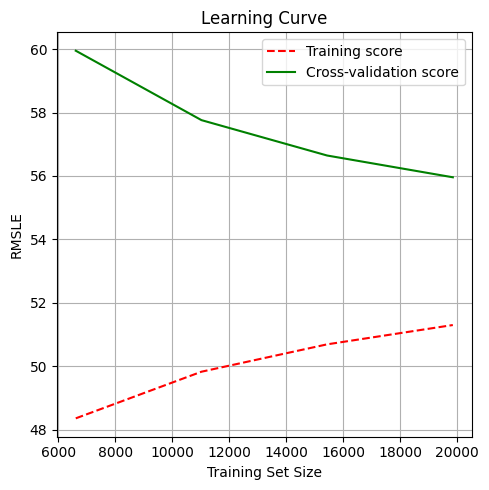

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [158]:
Des_tree1 = DecisionTreeRegressor(max_depth=8)
lc_plot(Des_tree1,Xtv,ytv)

### 5.1.2 Random Forest

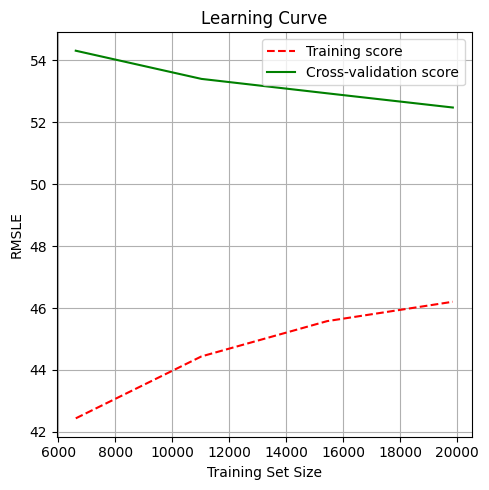

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [159]:
Rdm_forest1 = RandomForestRegressor(n_estimators = 15,max_depth = 9)
lc_plot(Rdm_forest,Xtv,ytv)

## 5.2 Método no supervisado + Método supervisado

### 5.2.1 PCA + Random Forest

In [160]:
X_ns2 = tabla_completa.drop(['price'],axis = 1)
y_ns2 = tabla_completa['price'].values

In [161]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
X_t1 = pca.fit_transform(X_ns2)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t1, y_ns2, test_size=test_size)
Rdm_forest3 = RandomForestRegressor(n_estimators = 15,max_depth = 9)

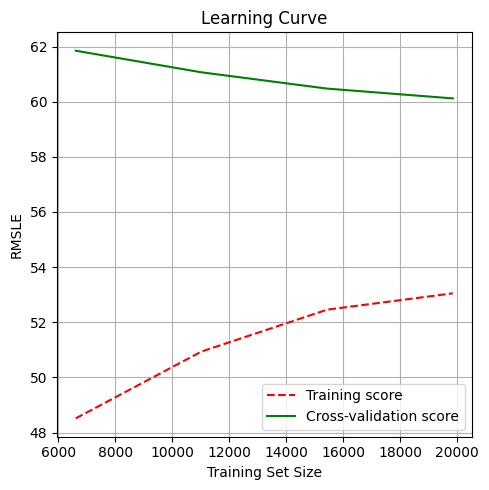

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [162]:
lc_plot(Rdm_forest3,Xtv,ytv)

### 5.2.2 NMF + Decision Tree

In [163]:
X2 = X_ns2.drop(['longitude'],axis=1)

In [164]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = 3)
X_t2 = nmf.fit_transform(X2)
test_size = 0.3
val_size  = test_size/(1-test_size)
Xtv, Xts, ytv, yts = train_test_split(X_t2, y, test_size=test_size)
Des_tree = DecisionTreeRegressor(max_depth=15)

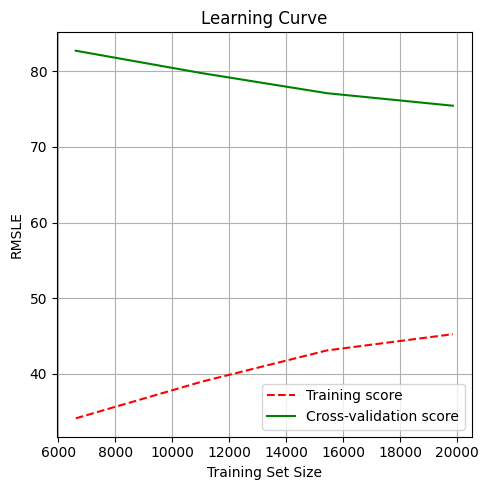

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

In [165]:
lc_plot(Des_tree,Xtv,ytv)